# Simple regression models - ShoreShop 2.0

Some simple regression models from old code. These are a nice baseline to explore the data, and get a feel for the process and alongshore behaviour. 
The code I have has the models estimate parameters for dx and then model y as:

`y = jnp.cumsum(f(x)) + e`

Things to deal with:

- check estimate y directly for the simplest models before building on dx style models
- autocorrelation in residuals (though low priority as not fussed about accuracy of uncertainty estimates)


In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from functions.data_load import load_modelling_data, tabularise_raw_data

## Load the data

Load the data using `load_modelling_data()` that returns a dictionary containing the following pandas DataFrames mirroring `1.data_explore.ipynb` (with indices as datetime objects where possible):

- `df_tran`: Transect data.
- `df_gt`: Groundtruth shoreline positions.
- `df_targ_short`: Short-term target shoreline positions.
- `df_targ_medium`: Medium-term target shoreline positions.
- `df_obs`: Observed shoreline positions.
- `dfs_wave`: Wave data for different parameters ('Hs', 'Tp', 'Dir').
- `df_SLR_obs`: Observed sea level rise data.
- `df_SLR_proj`: Projected sea level rise data.

Provided information:
A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [3]:
basedir = '.' # where are you in relation to the root directory
raw_data = load_modelling_data(basedir=basedir)

df_tran: Loaded 9 transects...
df_gt: Loaded (3, 9) (dates,transects) groundtruth shoreline positions...1999-06-20 to 2018-08-17
df_targ_short: Loaded (119, 9) (dates,transects) short-term target shoreline positions...2019-01-14 to 2023-12-27
df_targ_medium: Loaded (116, 9) (dates,transects) medium-term target shoreline positions...1951-05-01 to 1998-10-27
df_obs: Loaded (347, 9) (dates,transects) observed shoreline positions...1999-02-16 to 2018-12-29
dfs_wave["Hs"]: Loaded (30678, 9) (dates,transects) Hs wave data...
dfs_wave["Tp"]: Loaded (30678, 9) (dates,transects) Tp wave data...
dfs_wave["Dir"]: Loaded (30678, 9) (dates,transects) Dir wave data...
Wave data spans: 1940-01-02 to 2023-12-29 at 1 day(s) interval
df_SLR_obs: Loaded (38, 1) (years, ['SLR (mm)']) observed sea level rise data...1981 to 2018
df_SLR_proj: Loaded (82, 2) (years, ['RCP45', 'RCP85']) projected sea level rise data...2019 to 2100


## Optional preprocessing
Here is provided a template for optional preprocessing steps that can be used to tabularise the data for modelling. Adopted the frequency of the wave data, but this can of course be adjusted.

In [4]:
# Optional pre-processing
tabular_data = tabularise_raw_data(raw_data)

### Quick visualisation
Some quick visualisation of the data to show the format

/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

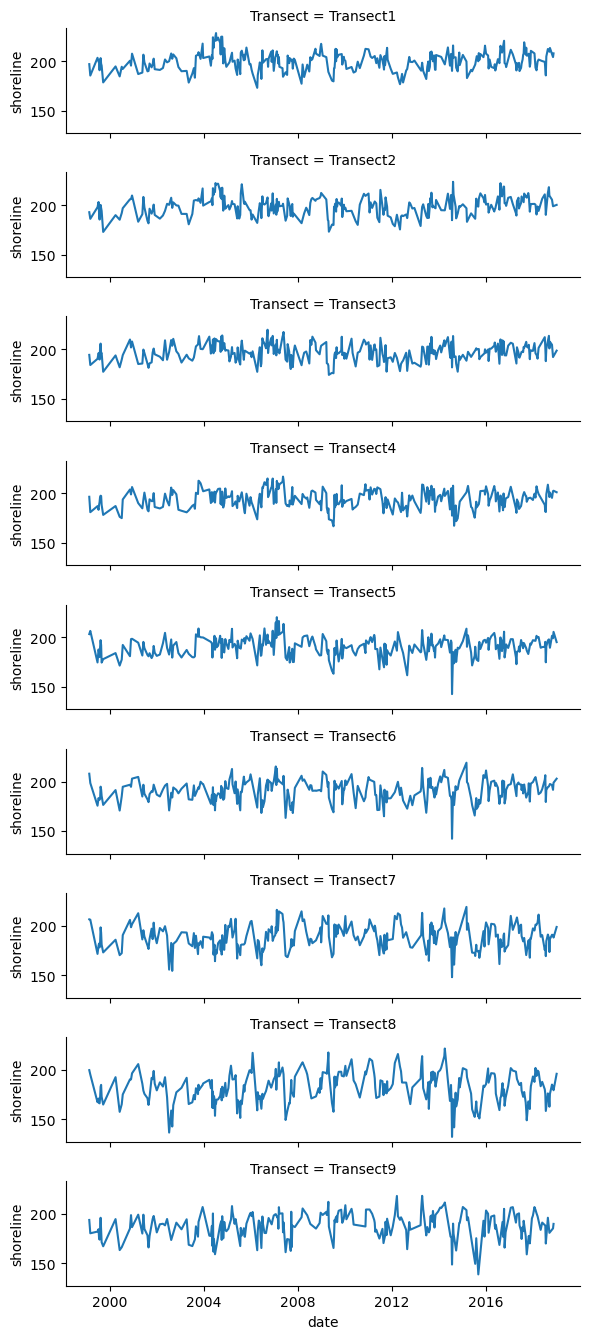

In [5]:
# vis of transect data
sns.FacetGrid(data=tabular_data['df_obs'],row='Transect', aspect=4, height=1.5).map_dataframe(sns.lineplot,y='shoreline',x='date')
plt.show()

/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

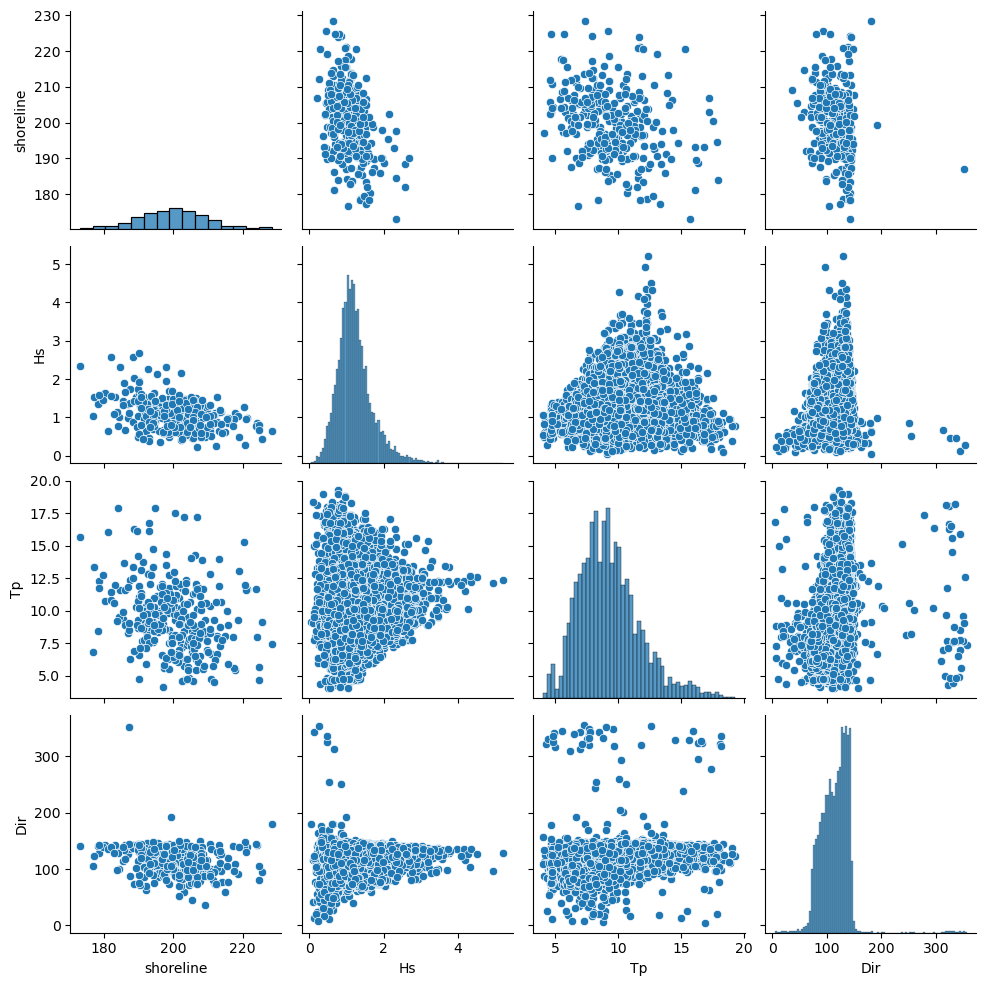

In [6]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

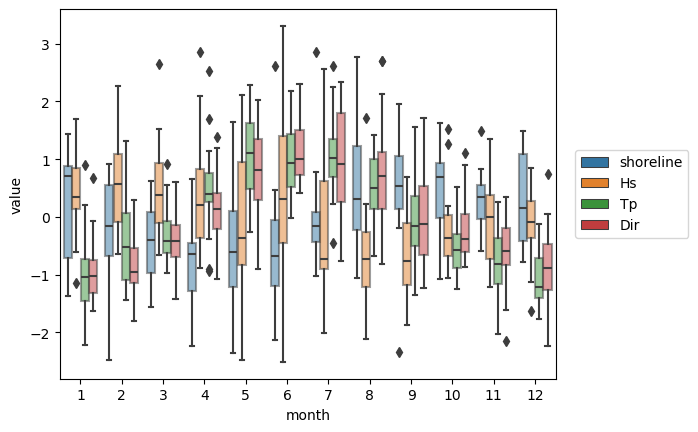

In [7]:
# plot the seasonal averages
trans_id = 'Transect1'
plot_data = tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('1ME').mean()
plot_data = plot_data.assign(month=plot_data.index.month)
# demean and stanardise the variables
for _ in [_ for _ in plot_data.columns if not _ in ['month']]:
    plot_data[_] = (plot_data[_] - plot_data[_].mean())/plot_data[_].std()
sns.boxplot(data=plot_data.melt(id_vars='month'),x='month',y='value',hue='variable',boxprops=dict(alpha=.5))
plt.legend(loc=6,bbox_to_anchor=(1.025,0.5))
plt.show()

## Modelling attempt
Here you can construct your model and make some predictions.

In [9]:
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp

# Local functions
from functions.inference import NumPyroSampler
from functions.np_plotting import plot_prediction_scatter, plot_prediction

from functions.models import (
    build_seasonal_linear_model,
    build_shladj_linear_model
)

### Prepare the data
Initially I will resample to monthly to avoid so many NaNs and other unpleasantries. Then we will cheekily gap fill the data, this will be a big exercise in missing data and the choice around how this is handled needs to be considered carefully.

In [10]:
# split per Transect then average to monthly values with mean and peak for Hs and Tp then recombine into a reasonable dataframe
resampled_data = tabular_data['df_obs'].copy()
resampled_data = pd.concat(
    [
        resampled_data.query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('MS').agg({'Hs':['mean','max'],'Tp':['mean','max'],'Dir':['mean'],'shoreline':['mean']}).reset_index().assign(Transect=trans_id) for trans_id in resampled_data['Transect'].unique()
    ], axis=0
)
# combine the column names to make one level
resampled_data.columns = [
    '_'.join(col).strip() if '' != col[1] else col[0] for col in resampled_data.columns.values]
resampled_data = resampled_data.rename(columns={'shoreline_mean':'shoreline'})
# now add month predictor
resampled_data = resampled_data.assign(month=resampled_data['date'].dt.month-1)
resampled_data

,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month
0,1999-02-01,1.661693,2.685259,10.288477,11.371681,110.466204,197.025794,Transect1,1
1,1999-03-01,1.294766,1.862510,8.780990,16.435893,110.464774,185.473336,Transect1,2
2,1999-04-01,1.772425,3.762188,10.478596,16.203715,122.393067,NaN,Transect1,3
3,1999-05-01,1.195522,2.796906,10.827863,18.867008,106.549393,NaN,Transect1,4
4,1999-06-01,1.248062,2.124438,9.277906,12.247637,125.319169,203.434419,Transect1,5
...,...,...,...,...,...,...,...,...,...
234,2018-08-01,1.011250,2.536892,10.716873,15.233035,115.534353,195.940861,Transect9,7
235,2018-09-01,1.106997,1.693026,9.220982,15.896701,113.840845,180.674962,Transect9,8
236,2018-10-01,1.430727,2.300577,9.086596,16.123380,107.333152,NaN,Transect9,9
237,2018-11-01,1.145680,2.581402,8.718028,18.943418,113.744590,187.439058,Transect9,10


/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/build/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

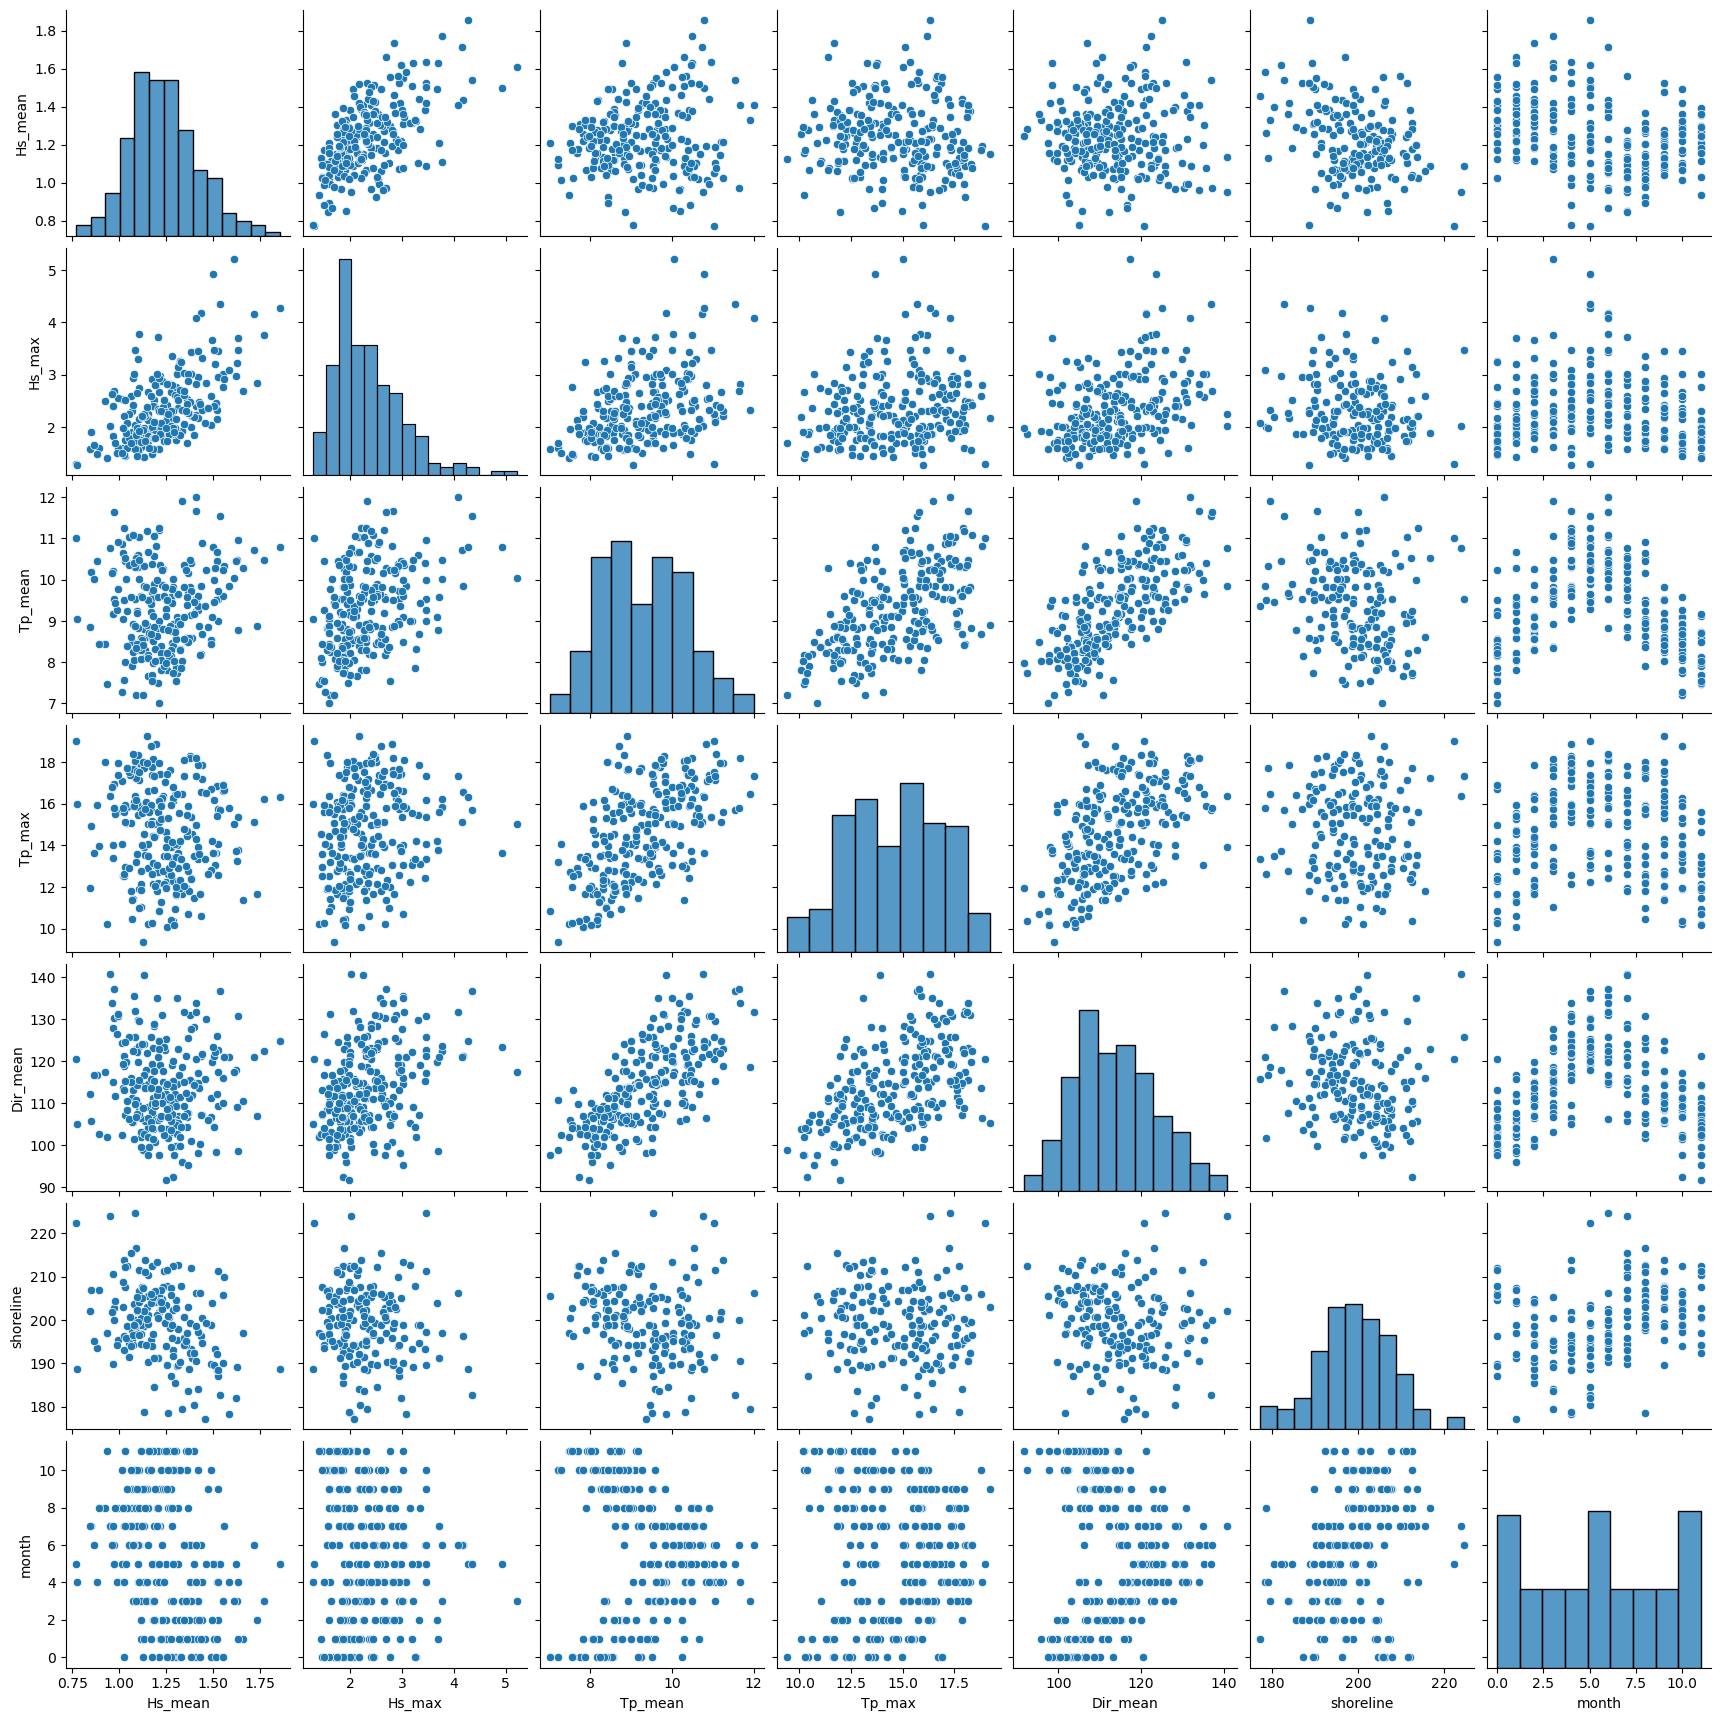

In [11]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    resampled_data.query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

In [12]:
x_vars = ['Hs_mean','Hs_max','Tp_mean','Tp_max','Dir_mean','month']
y_vars = ['shoreline']
tran_var = 'Transect'

# Make standardised data
# standardised_data = tabular_data['df_obs'].copy()
standardised_data = resampled_data
# bend it into a 3D frame
print('Unique transects: {}'.format(standardised_data[tran_var].unique()))
jnp_X = jnp.array(np.stack(
    [
        standardised_data.query('Transect == @trans_id')[x_vars].values for trans_id in standardised_data[tran_var].unique()
    ], axis=1
))

df_Y = pd.pivot_table(standardised_data, index='date', columns='Transect', values=y_vars[0], dropna=False)

jnp_Y = np.stack(
    [
        standardised_data.query('Transect == @trans_id')[y_vars].values for trans_id in standardised_data[tran_var].unique()
    ],
    axis=1
).squeeze()

# # fill nan with mean value
# jnp_Y = np.where(np.isnan(jnp_Y), np.nanmean(jnp_Y), jnp_Y)
# fill nan with linear interpolated value
for i in range(jnp_Y.shape[1]):
    jnp_Y[:,i] = np.where(np.isnan(jnp_Y[:,i]), np.interp(np.arange(jnp_Y.shape[0]), np.arange(jnp_Y.shape[0])[~np.isnan(jnp_Y[:,i])], jnp_Y[:,i][~np.isnan(jnp_Y[:,i])]), jnp_Y[:,i])

jnp_Y = jnp.array(jnp_Y)

# store jnp_T as an int by category
jnp_T = jnp.array(standardised_data[tran_var].astype('category').cat.codes.values)



print('jnp_X.shape: {}, isnan: {}'.format(jnp_X.shape, np.isnan(jnp_X).sum()))
print('jnp_Y.shape: {}, isnan: {}'.format(jnp_Y.shape, np.isnan(jnp_Y).sum()))
print('jnp_T.shape: {}, isnan: {}'.format(jnp_T.shape, np.isnan(jnp_T).sum()))

Unique transects: ['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']
jnp_X.shape: (239, 9, 6), isnan: 0
jnp_Y.shape: (239, 9), isnan: 0
jnp_T.shape: (2151,), isnan: 0


### Prepare the models and check priors
We will compare several models, at first just trying to build the most basic model (seasonal) as a baseline for more complex models. The idea is to keep the models simple regression constructions rather than jumping to non-linear setups. The aim is to tell a story with the simplest of models to see how much more perfomance can be wringed out when compared to others' more complex models.

- `linear_seasonal_model`: Seasonal term with more flexibility (param learned for each transect/month) and linear trend.
- `linear_shladj_model`: Seasonal term with more flexibility (param learned for each transect/month), linear trend, and wave data (Hsig, Tp, Dir) as input.

In [13]:
ci = 0.89

# a lazy but more flexible way to code in seasonality creating a lot of new params.
linear_seasonal_model = build_seasonal_linear_model()
# define sampler
linear_seasonal_sampler = NumPyroSampler(
    jnp_X,
    jnp_Y,
    jnp_Y[0,:],
    model=linear_seasonal_model,
    ci=ci,
    seed=2024
)

# simple linear model
linear_shladj_model = build_shladj_linear_model()
# define sampler
linear_shladj_sampler = NumPyroSampler(
    jnp_X,
    jnp_Y,
    jnp_Y[0,:],
    model=linear_shladj_model,
    ci=ci,
    seed=2024
)

In [14]:
arviz_priors, prior_predictive = linear_shladj_sampler.prior_predictive_check(num_samples=100)

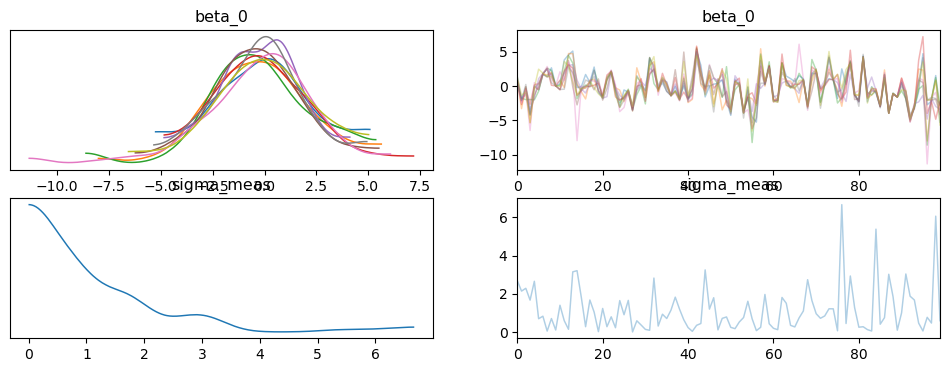

In [15]:
az.plot_trace(arviz_priors.prior, var_names=['beta_0','sigma_meas'])
None

In [16]:
prior_predictive['mean_mu_prior'].shape
jnp_Y.shape

(239, 9)

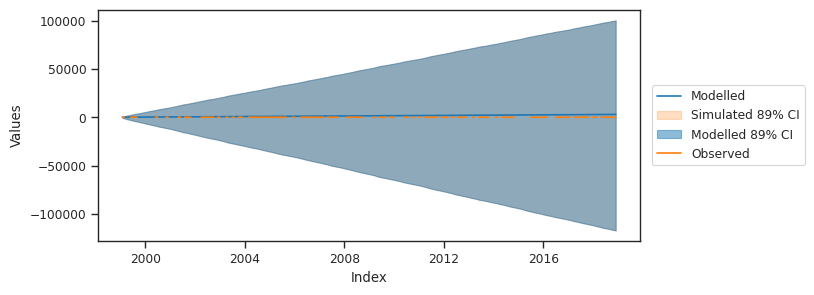

In [17]:
plot_prediction(
    df_Y,
    prior_predictive['mean_mu_prior'],
    prior_predictive['hpdi_mu_prior'],
    prior_predictive['hpdi_sim_prior'],
    tran_id = 1,
    ci=ci
)

### Sample the models
We will sample each of the models using MCMC.

In [18]:
# settings 
sampler = 'NUTS'
num_samples = 500
num_warmup = 500
num_chains = 8
max_tree = 10
step_size = 0.01 #75
n_train = 15000
n_predictive = n_train
save_bool = False # save to arviz netcdf
load_bool = False # load previous runs from arviz netcdf
extract_vars = ['mu','sigma_meas','obs'] # variables to extract from posterior_predictive
# variables to check in posterior

check_vars = {
    'linear_seasonal_model': [
        'beta_0','beta_month'
    ],
    'linear_shladj_model': [
        'beta_0','beta_month','beta_Hsig_0', 'beta_Hsig_max', 'beta_Hsig_dir', 'beta_Tp_0', 'alpha_Hsig_0', 'alpha_Hsig_max', 'alpha_Hsig_dir', 'alpha_Tp_0'
    ]
}

kernels_models = {
    'linear_seasonal_model': (linear_seasonal_sampler,linear_seasonal_model),
    'linear_shladj_model': (linear_shladj_sampler,linear_shladj_model)
}

rng_key_ = random.PRNGKey(2024)

mcmc_outputs = {}
# run the sampler
for model_name, (sampler, model) in kernels_models.items():
    print('Running {}'.format(model_name))
    sampler.run_sampler(
        rng_key=rng_key_,
        num_samples=num_samples,
        num_warmup=num_warmup,
        num_chains=num_chains,
        max_tree=max_tree,
        extract_vars=extract_vars,
    )

    # # get forward predicion
    # results_forward = sampler.predict_forward(
    #     rng_key=rng_key_,
    #     extract_vars=extract_vars
    # )

    mcmc_outputs[model_name] = {
        'arviz_posterior': sampler.arviz,
        'mean_mu': sampler.results['mean_mu_train'],
        'hpdi_mu': sampler.results['hpdi_mu_train'],
        'hpdi_sim': sampler.results['hpdi_sim_train'],
        # 'mean_mu_test': sampler.results['mean_mu_test'],
        # 'hpdi_mu_test': sampler.results['hpdi_mu_test'],
        # 'hpdi_sim_test': sampler.results['hpdi_sim_test'],
        # 'ts_mean_mu': results_forward['mean_mu'],
        # 'ts_hpdi_mu': results_forward['hpdi_mu'],
        # 'ts_hpdi_sim': results_forward['hpdi_sim'],
        # 'ts_mean_mu_test': results_forward['mean_mu_test'],
        # 'ts_hpdi_mu_test': results_forward['hpdi_mu_test'],
        # 'ts_hpdi_sim_test': results_forward['hpdi_sim_test']
    }


Running linear_seasonal_model


/build/miniconda3/lib/python3.10/site-packages/jax/_src/linear_util.py:192: UserWarning: Missing a plate statement for batch dimension -2 at site 'beta_month'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running linear_shladj_model


/build/miniconda3/lib/python3.10/site-packages/jax/_src/linear_util.py:192: UserWarning: Missing a plate statement for batch dimension -2 at site 'beta_month'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Examine the posteriors
Here we can examine the parameters, their posteriors and comapre between models.

################################################################################
Posterior


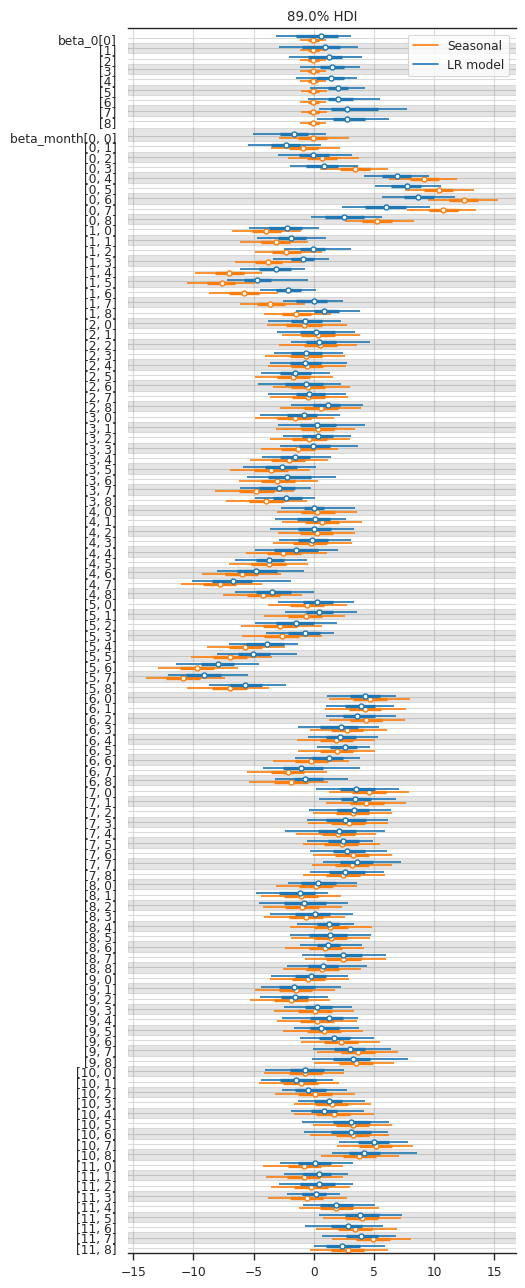

In [20]:
this_model1 = 'linear_shladj_model'
this_model2 = 'linear_seasonal_model'
print('#'*80)
print('Posterior')
# sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,35))
ax1 = plt.subplot(211)
az.plot_forest(
    [
        mcmc_outputs[this_model1]['arviz_posterior'],
        mcmc_outputs[this_model2]['arviz_posterior']
    ],
    var_names=check_vars[this_model2],
    hdi_prob=ci,
    model_names=['LR model','Seasonal'],#,'Mix model'],
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
# turn on grid black with alpha 0.5 for this ax1
ax1.grid(color='xkcd:light grey')
None

In [21]:
# for this_model in mcmc_outputs.keys():
#     print('#'*80)
#     print('Model: {}'.format(this_model))
#     az.plot_trace(
#         mcmc_outputs[this_model]['arviz_posterior'], var_names=check_vars[this_model]
#     )

Check for convergence

In [22]:
for this_model in mcmc_outputs.keys():
    print('#'*80)
    print('Model: {}'.format(this_model))
    display(az.rhat(
        mcmc_outputs[this_model]['arviz_posterior'],
        var_names=check_vars[this_model]
    ))

################################################################################
Model: linear_seasonal_model


<xarray.Dataset> Size: 1kB
Dimensions:           (beta_0_dim_0: 9, beta_month_dim_0: 12,
                       beta_month_dim_1: 9)
Coordinates:
  * beta_0_dim_0      (beta_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_month_dim_0  (beta_month_dim_0) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * beta_month_dim_1  (beta_month_dim_1) int64 72B 0 1 2 3 4 5 6 7 8
Data variables:
    beta_0            (beta_0_dim_0) float64 72B 1.062 1.064 ... 1.063 1.063
    beta_month        (beta_month_dim_0, beta_month_dim_1) float64 864B 1.008...

################################################################################
Model: linear_shladj_model


<xarray.Dataset> Size: 2kB
Dimensions:              (beta_0_dim_0: 9, beta_month_dim_0: 12,
                          beta_month_dim_1: 9, beta_Hsig_0_dim_0: 9,
                          beta_Hsig_max_dim_0: 9, beta_Hsig_dir_dim_0: 9,
                          beta_Tp_0_dim_0: 9)
Coordinates:
  * beta_0_dim_0         (beta_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Hsig_0_dim_0    (beta_Hsig_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Hsig_dir_dim_0  (beta_Hsig_dir_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Hsig_max_dim_0  (beta_Hsig_max_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Tp_0_dim_0      (beta_Tp_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_month_dim_0     (beta_month_dim_0) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * beta_month_dim_1     (beta_month_dim_1) int64 72B 0 1 2 3 4 5 6 7 8
Data variables:
    beta_0               (beta_0_dim_0) float64 72B 2.175 1.877 ... 1.897 1.632
    beta_month           (beta_month_dim_0, beta_month_dim_1) float64 864B 1....
    beta_Hsig_0          (beta_Hsig_0_dim_0) float64 72B 1.774 1.659 ... 1.377
    beta_Hsig_max        (beta_Hsig_max_dim_0) float64 72B 1.463 1.473 ... 1.249
    beta_Hsig_dir        (beta_Hsig_dir_dim_0) float64 72B 1.276 1.324 ... 1.391
    beta_Tp_0            (beta_Tp_0_dim_0) float64 72B 1.666 1.517 ... 1.456
    alpha_Hsig_0         float64 8B 1.469
    alpha_Hsig_max       float64 8B 1.121
    alpha_Hsig_dir       float64 8B 1.378
    alpha_Tp_0           float64 8B 1.261

### Compare model skill
Compare the skill of each model by RMSE, R2 (of dShl), BSS.

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

def calc_skill(curr_obs,prev_obs,mean_mu):
    good_idx = np.where(~np.isnan(curr_obs) & ~np.isnan(prev_obs))[0]
    if np.any(np.isnan(mean_mu)) or np.any(np.abs(mean_mu)>1e20):
        print('Mean mu has NaNs')
        return np.nan, np.nan
    # calc RMSE
    rmse = np.sqrt(mean_squared_error(curr_obs.iloc[good_idx],mean_mu[good_idx]))
    # calc R
    dx = curr_obs.iloc[good_idx].values[1:] - curr_obs.iloc[good_idx].values[:-1] 
    dx_pred = mean_mu[good_idx][1:] - mean_mu[good_idx][:-1]
    r2 = r2_score(dx,dx_pred)
    # calc BSS vs persistence
    bss = 1 - (np.sum((curr_obs.iloc[good_idx] - mean_mu[good_idx])**2)/np.sum((curr_obs.iloc[good_idx] - prev_obs.iloc[good_idx])**2))
    return rmse, r2, bss

def print_skill(models,df, mu_var='mean_mu'):
    # Calculate BSS, RMSE and R and print each for the models in models
    model_avg_bss = {_:[] for _ in models.keys()}
    model_avg_rmse = {_:[] for _ in models.keys()}
    model_avg_r2 = {_:[] for _ in models.keys()}
    for this_tran in df.columns:
        print('# {}'.format(this_tran))
        for this_mod in models.keys():
            rmse, r2, bss = calc_skill(df[this_tran],df[this_tran].shift(1),models[this_mod][mu_var][:,df.columns.get_loc(this_tran)])
            print('{} - {}: BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f}'.format(this_mod,this_tran,bss,rmse,r2))
            model_avg_bss[this_mod].append(bss)
            model_avg_rmse[this_mod].append(rmse)
            model_avg_r2[this_mod].append(r2) 
    print('# Overall')
    for this_mod in models.keys():
        print('Model - {}: BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f}'.format(this_mod,np.nanmean(model_avg_bss[this_mod]),np.nanmean(model_avg_rmse[this_mod]),np.nanmean(model_avg_r2[this_mod])))

In [32]:
# report the RMSE, BSS and R2
print('#'*80)
print('Train - one step')
print_skill(mcmc_outputs,df_Y,mu_var='mean_mu')
# print('Test - one step')
# print_skill(mcmc_outputs,df_Y,mu_var='mean_mu_test')
# print('#'*80)
# print('Train - timeseries')
# print_skill(mcmc_outputs,df_Y,mu_var='ts_mean_mu')
# print('Test - timeseries')
# print_skill(mcmc_outputs,test_ts_df,mu_var='ts_mean_mu_test')

################################################################################
Train - one step
# Transect1
linear_seasonal_model - Transect1: BSS: 0.08 | RMSE: 7.83 | R2: 0.18
linear_shladj_model - Transect1: BSS: 0.22 | RMSE: 7.18 | R2: 0.22
# Transect2
linear_seasonal_model - Transect2: BSS: 0.21 | RMSE: 8.03 | R2: 0.18
linear_shladj_model - Transect2: BSS: 0.35 | RMSE: 7.25 | R2: 0.20
# Transect3
linear_seasonal_model - Transect3: BSS: 0.45 | RMSE: 7.01 | R2: 0.14
linear_shladj_model - Transect3: BSS: 0.51 | RMSE: 6.61 | R2: 0.13
# Transect4
linear_seasonal_model - Transect4: BSS: 0.24 | RMSE: 7.31 | R2: 0.08
linear_shladj_model - Transect4: BSS: 0.34 | RMSE: 6.84 | R2: 0.10
# Transect5
linear_seasonal_model - Transect5: BSS: 0.36 | RMSE: 7.11 | R2: 0.07
linear_shladj_model - Transect5: BSS: 0.46 | RMSE: 6.56 | R2: 0.14
# Transect6
linear_seasonal_model - Transect6: BSS: 0.47 | RMSE: 7.90 | R2: 0.17
linear_shladj_model - Transect6: BSS: 0.49 | RMSE: 7.73 | R2: 0.20
# Transect7
li

### Plot the model results
Plot the model results and compare to the observed data.

################################################################################
linear_seasonal_model - Transect1


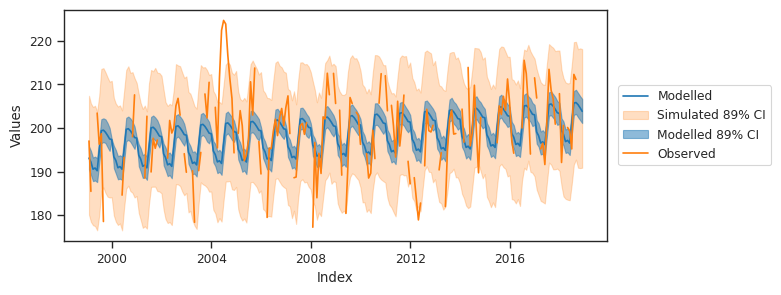

################################################################################
linear_shladj_model - Transect1


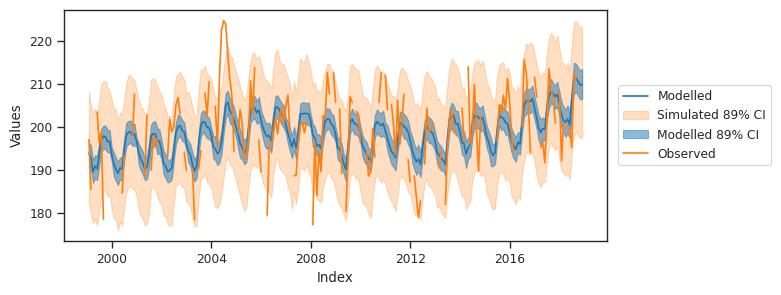

################################################################################
linear_seasonal_model - Transect2


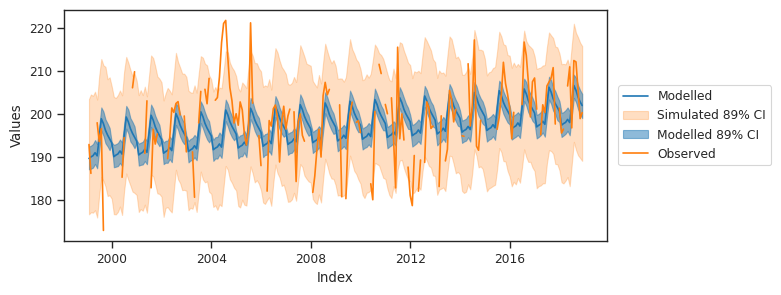

################################################################################
linear_shladj_model - Transect2


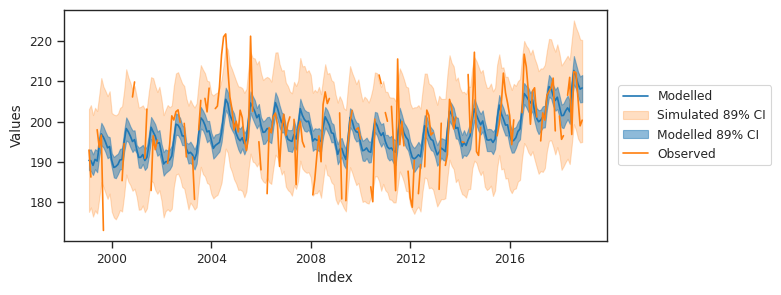

################################################################################
linear_seasonal_model - Transect3


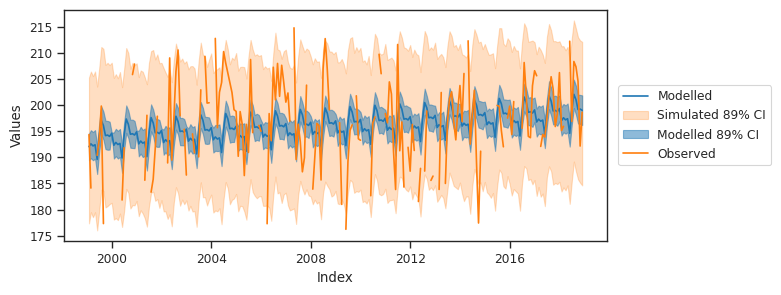

################################################################################
linear_shladj_model - Transect3


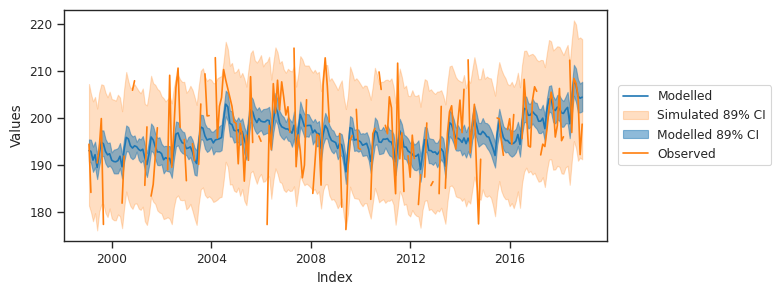

################################################################################
linear_seasonal_model - Transect4


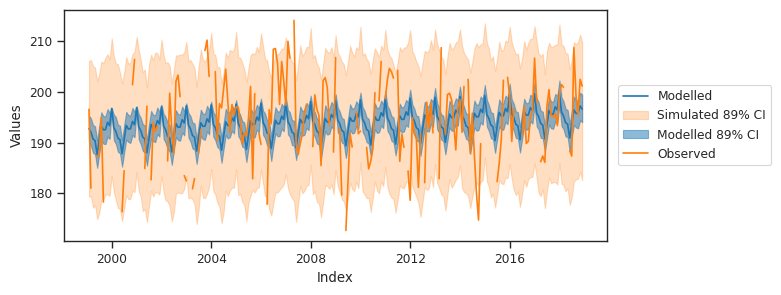

################################################################################
linear_shladj_model - Transect4


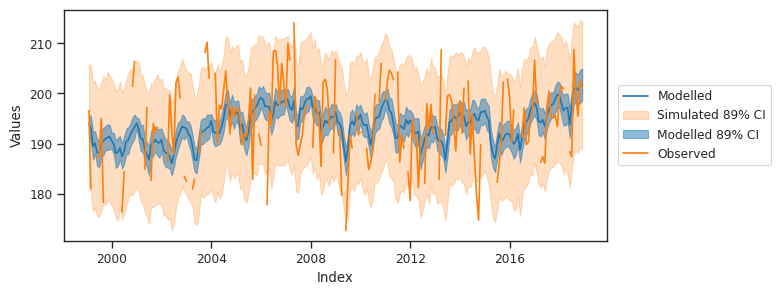

################################################################################
linear_seasonal_model - Transect5


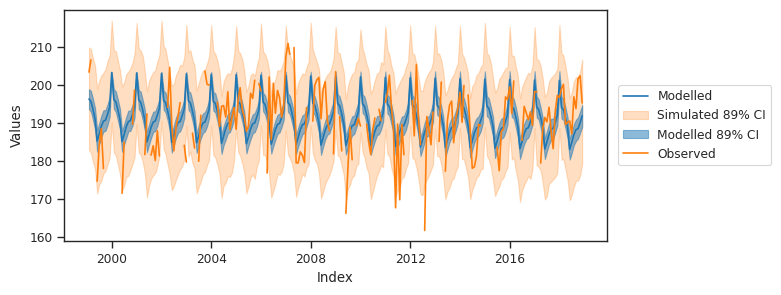

################################################################################
linear_shladj_model - Transect5


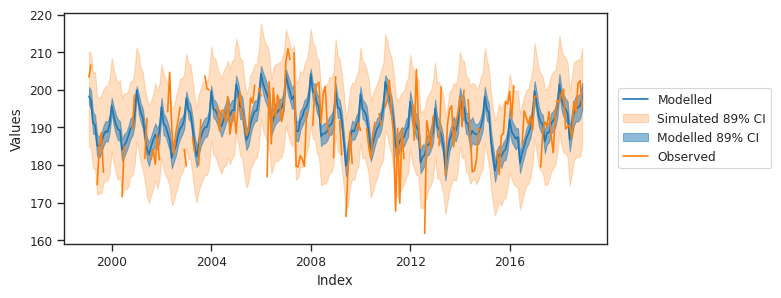

################################################################################
linear_seasonal_model - Transect6


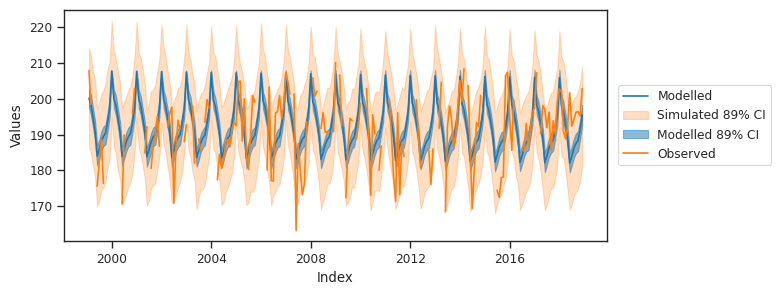

################################################################################
linear_shladj_model - Transect6


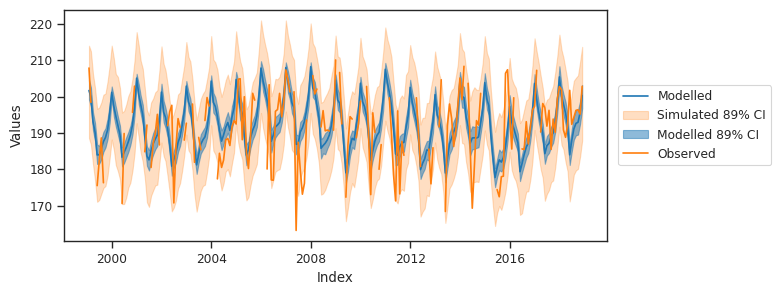

################################################################################
linear_seasonal_model - Transect7


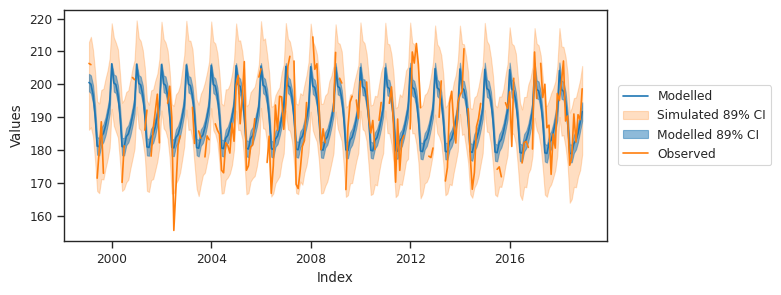

################################################################################
linear_shladj_model - Transect7


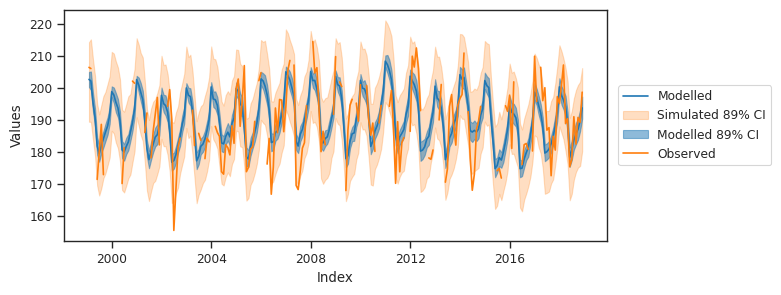

################################################################################
linear_seasonal_model - Transect8


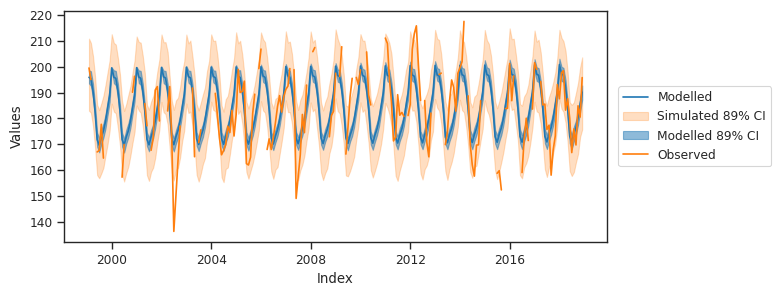

################################################################################
linear_shladj_model - Transect8


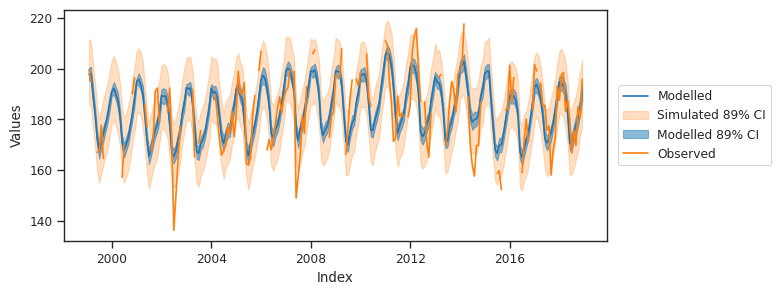

################################################################################
linear_seasonal_model - Transect9


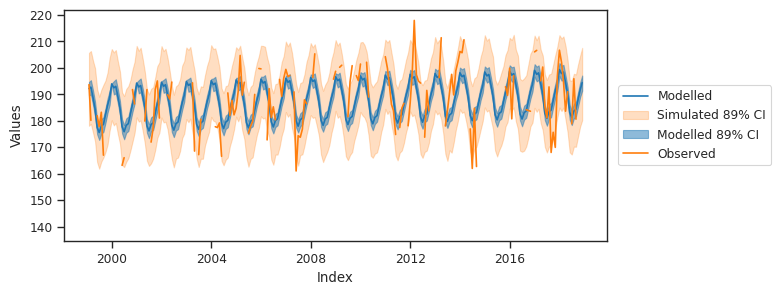

################################################################################
linear_shladj_model - Transect9


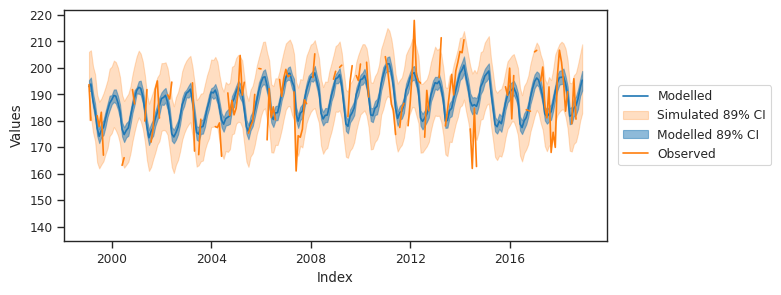

In [33]:
plot_models = mcmc_outputs.keys()

for tran_id, tran_name in enumerate(df_Y.columns):
    for this_model in plot_models:
        print('#'*80)
        print('{} - {}'.format(this_model, tran_name))
        plot_prediction(
            df_Y,
            mcmc_outputs[this_model]['mean_mu'],
            mcmc_outputs[this_model]['hpdi_mu'],
            mcmc_outputs[this_model]['hpdi_sim'],
            tran_id=tran_id,
            ci=ci
        )
        # plot_prediction_scatter(
        #     df_Y,
        #     mcmc_outputs[this_model]['mean_mu'],
        #     mcmc_outputs[this_model]['hpdi_mu'],
        #     mcmc_outputs[this_model]['hpdi_sim'],
        #     tran_id=1,
        #     ci=ci
        # )